In [1]:
import cv2
from tqdm import tqdm
import os
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image_dir = 'data/images/val'
label_dir = 'data/labels/val'

classes = [
    'pedestrian',
    'bicycle',
    'car',
    'motorcycle',
    'rider',
    'bus',
    'train',
    'truck',
    'traffic sign',
    'traffic light'
]

coco_output = {
    "info": {}, # quite important - det_val.json doest not have this field and cocotools require this field
    "licenses": [],
    "images": [],
    "annotations": [],
    "categories": []
}

# add categories
for idx, class_name in enumerate(classes, 1):
    coco_output['categories'].append({
        "id": idx,
        "name": class_name,
        "supercategory": "object"
    })

annotation_id = 1

for img_id, img_file in enumerate(tqdm(os.listdir(image_dir)), 1):
    if not img_file.endswith(('.jpg', '.png', '.jpeg')):
        continue

    img_path = os.path.join(image_dir, img_file)
    img = cv2.imread(img_path)
    h, w, _ = img.shape

    coco_output['images'].append({
        "id": img_id,
        "file_name": img_file,
        "height": h,
        "width": w
    })

    # search for correct label
    label_file = os.path.splitext(img_file)[0] + '.txt'
    label_path = os.path.join(label_dir, label_file)
    if not os.path.exists(label_path):
        continue

    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0]) + 1  # COCO class_id starts with 1
        x_center, y_center, bbox_width, bbox_height = map(float, parts[1:])

        x = (x_center - bbox_width / 2) * w
        y = (y_center - bbox_height / 2) * h
        width_abs = bbox_width * w
        height_abs = bbox_height * h

        annotation = {
            "id": annotation_id,
            "image_id": img_id,
            "category_id": class_id,
            "bbox": [x, y, width_abs, height_abs],
            "area": width_abs * height_abs,
            "iscrowd": 0
        }
        coco_output['annotations'].append(annotation)
        annotation_id += 1

with open('data/annotations/converted_coco.json', 'w') as outfile:
    json.dump(coco_output, outfile, indent=4)

print("Konwersja zakończona!")


100%|██████████| 20000/20000 [00:15<00:00, 1268.97it/s]


Konwersja zakończona!


In [3]:
gt_path = 'data/annotations/converted_coco.json'
pred_path = 'runs/detect/whole2-val-last/predictions.json'

with open(gt_path) as f:
    gt = json.load(f)

filename_to_id = {os.path.splitext(img['file_name'])[0]: img['id'] for img in gt['images']}

with open(pred_path) as f:
    preds = json.load(f)

for pred in preds:
    file = os.path.splitext(os.path.basename(pred['image_id']))[0]
    pred['image_id'] = filename_to_id[file]

with open(pred_path, 'w') as f:
    json.dump(preds, f)


In [4]:
gt_path = 'data/annotations/converted_coco.json'
pred_path = 'runs/detect/whole2-val-last/predictions.json'

cocoGt = COCO(gt_path)
with open(pred_path) as f:
    preds = json.load(f)
cocoDt = cocoGt.loadRes(preds)

cocoEval = COCOeval(cocoGt, cocoDt, iouType='bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

# global mAP
mAP_50_95 = cocoEval.stats[0]
mAP_50 = cocoEval.stats[1]

print(f'mAP@[0.50:0.95]: {mAP_50_95:.3f}')
print(f'mAP@0.50: {mAP_50:.3f}')


loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=38.49s).
Accumulating evaluation results...
DONE (t=4.23s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.453
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.077
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.503
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Podstay detekcji obiektów:

 - Detektor przewiduje:

    - lokalizację: prostokąt (bounding box)

    - klasę: np. "pedestrian", "car" itd.

 - Ewaluacja polega na porównaniu predykcji z rzeczywistą pozycją obiektu (ground truth)

 - Kluczowe pojęcie: IoU (Intersection over Union)

     - mówi o tym jak bardzo na siebie nachodzą predykowany i prawdziwy bounding box.

     - IoU = powierzchnia wspólna / powierzchnia sumy.

mAP = średnia precyzja po różnych wartościach IoU i klasach.

Oznacza:

   - liczymy AP dla IoU: 0.5, 0.55, 0.60, ..., 0.95 (co 0.05)

   - średnia z tych 10 wyników = mAP@[0.5:0.95]

Dlaczego to robimy?
Bo chcemy wiedzieć, czy detektor dobrze przewiduje nie tylko przybliżone ale też precyzyjne pozycje obiektów.

In [5]:
T = cocoEval.eval['precision'].shape

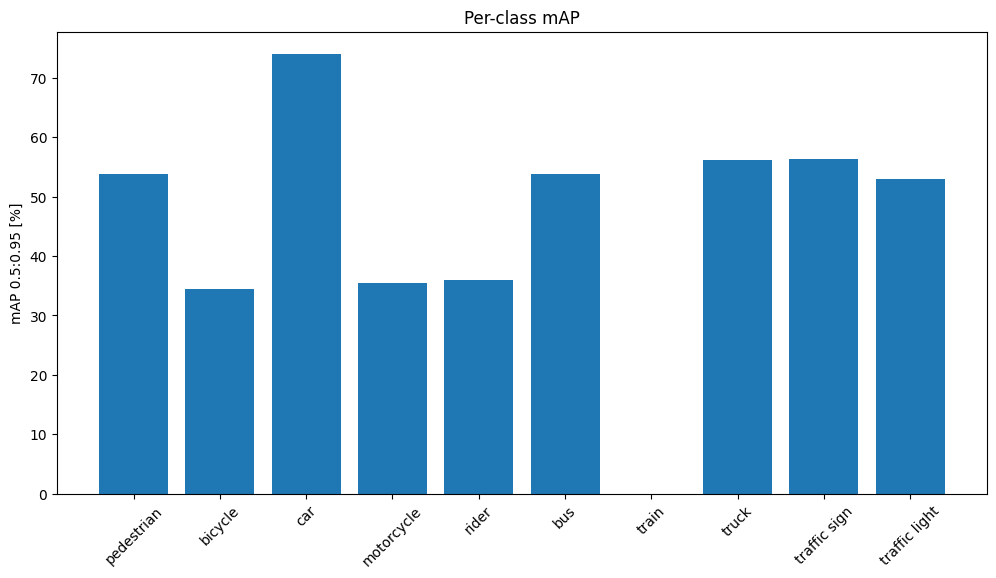

In [6]:
class_names = ['pedestrian', 'bicycle', 'car', 'motorcycle', 'rider', 'bus', 'train', 'truck', 'traffic sign', 'traffic light']

precisions = cocoEval.eval['precision']
iou_thr = 0  #  0 means 0.5:0.95 mAP

per_class_ap = []

for i, class_name in enumerate(class_names):
    precision = precisions[iou_thr, :, i, 0, 2]  # area=all, maxDets=100
    precision = precision[precision > -1]
    ap = np.mean(precision) if precision.size else 0
    per_class_ap.append(ap * 100)

# plots
plt.figure(figsize=(12, 6))
plt.bar(class_names, per_class_ap)
plt.ylabel('mAP 0.5:0.95 [%]')
plt.xticks(rotation=45)
plt.title('Per-class mAP')
plt.show()


Dzielimy obiekty wg wielkości (przez powierzchnię bboxa)

Model gorzej wykrywa małe obiekty (small) — bo są trudniejsze: mniej pikseli, gorzej widoczne.

Najlepiej radzi sobie z dużymi obiektami.

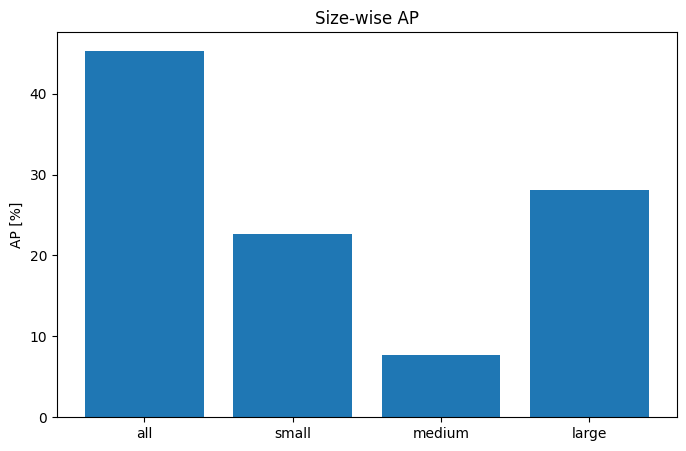

In [7]:
# small, medium, large:
# 0: all
# 1: small
# 2: medium
# 3: large

size_labels = ['all', 'small', 'medium', 'large']

ap_sizewise = []
for i in range(4):
    ap = cocoEval.stats[1 + i] * 100  # stats[1] = small, [2]=medium, [3]=large
    ap_sizewise.append(ap)

plt.figure(figsize=(8, 5))
plt.bar(size_labels, ap_sizewise)
plt.ylabel('AP [%]')
plt.title('Size-wise AP')
plt.show()
